# EDA

下記ステップを踏んで進める．

1. 問題を理解する
2. 目的変数(SalePrice)を調べる
3. 説明変数と目的変数の相関を調べる
4. 簡単な前処理
  - 欠損値
  - 外れ値
  - categorical data
5. 仮定の確認


参照:
- [COMPREHENSIVE DATA EXPLORATION WITH PYTHON | Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- 問題: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
%matplotlib inline

In [2]:
df_train = pd.read_feather('../data/input/train.feather')

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. So... What can we expect?

EDA を行うことで，簡単な仮説を立てる．
そのために下記を理解する．
これをスプレッドシートにまとめてみるとよい．

- Variable
- Type: numerical / categorical
- Segment: building / space / location
- Expectation: その変数が目的変数にどの程度影響しそうか．主観的な予測．high / medium / low
- Conclusion
- Comments

Expectation については下記に注意する．

- 実際に自分が家を買うとして，その変数を考慮するか
- もしそうなら，どの程度重要と考えるか
- その情報は別の変数に含まれていないか

結果，下記の要素が重要と判断した．

- MSSubClass(categorical)
- LotArea(numerial)
- LandContour(categorical)
- BldgType(categorical)
- OverallQual(categorical)
- YearBuilt(categorical)
- TotalBsmtSF(numerical)
- PoolArea(numerical)
- MiscVal(numerical)

data/input/eda_expectation.csv に保存した．
このうち，扱いやすさから，numerical data についてみていく．

## 2. First things first: analysing 'SalePrice'

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

とりあえず，最小値が 0 より大きいことがわかり，おそらく間違いのないデータと思われる．

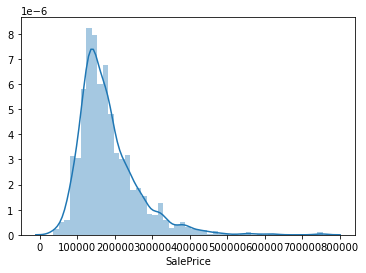

In [5]:
sns.distplot(df_train['SalePrice']);

このグラフからわかることは以下のとおり．

- 正規分布ではない
- かなり正の歪度がある
- 尖っている

In [6]:
print('Skewness: {s:.3f}'.format(s=df_train['SalePrice'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train['SalePrice'].kurt()))

Skewness: 1.883
Kurtosis: 6.536


注)  

Skewness: 歪度(3 次のモーメント)  

$\alpha_3 = E(X - \mu)^3 / \sigma^3$  

- $\alpha_3 < 0$: 左の裾が長い
- $\alpha_3 > 0$: 右の裾が長い

Kurtosis: 尖度(4 次のモーメント)  

$\alpha_4 = E(X - \mu)^4 / \sigma^4$  

- $\alpha_4 < 0$: 正規分布の方が尖っている
- $\alpha_4 > 0$: 正規分布より尖っている

### Numerical データとの関係

相関を調べてみる．  

先程，重要と推測した下記変数のうち，numerical データとの相関を調べる．

- LotArea(numerial)
- TotalBsmtSF(numerical)
- PoolArea(numerical)
- MiscVal(numerical)

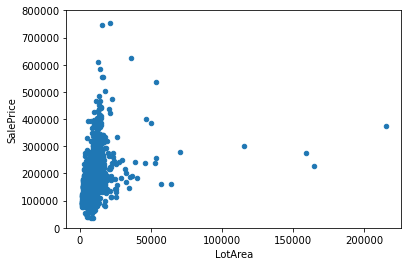

In [7]:
var = 'LotArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

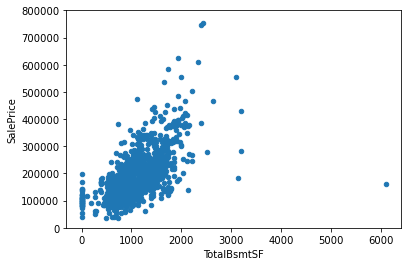

In [8]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

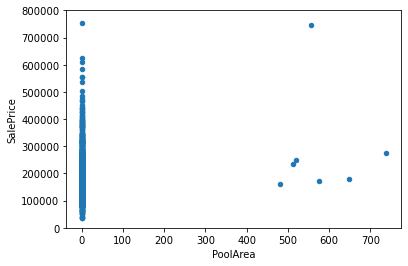

In [9]:
var = 'PoolArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

PoolArea: 関係ない

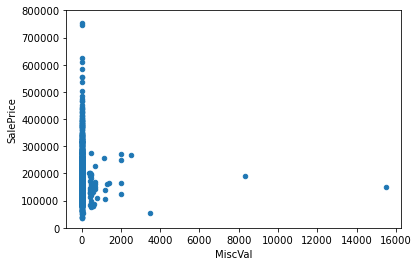

In [10]:
var = 'MiscVal'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

MiscVal: 関係ない

### Categorical データとの関係

相関を調べてみる．  

先程，重要と推測した下記変数のうち，categorical データとの相関を調べる．

- MSSubClass(categorical)
- LandContour(categorical)
- BldgType(categorical)
- OverallQual(categorical)
- YearBuilt(categorical)

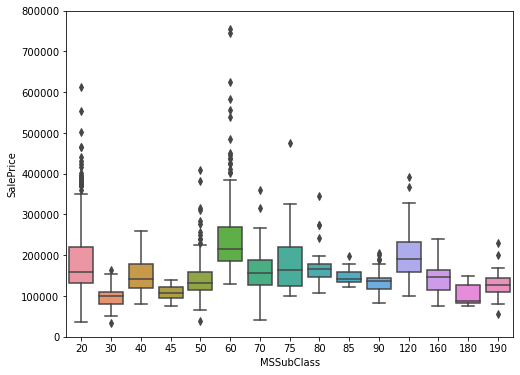

In [11]:
var = 'MSSubClass'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

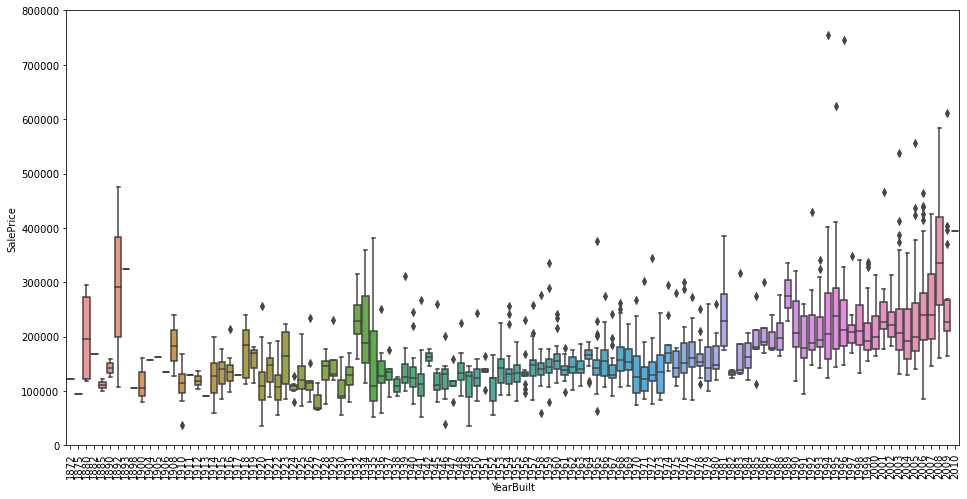

In [12]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

新しい方が高い傾向があると言えそう．

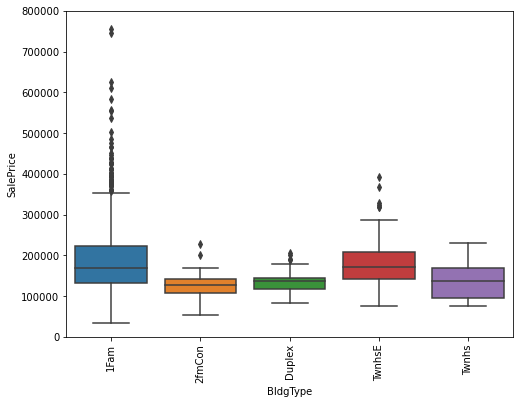

In [13]:
var = 'BldgType'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

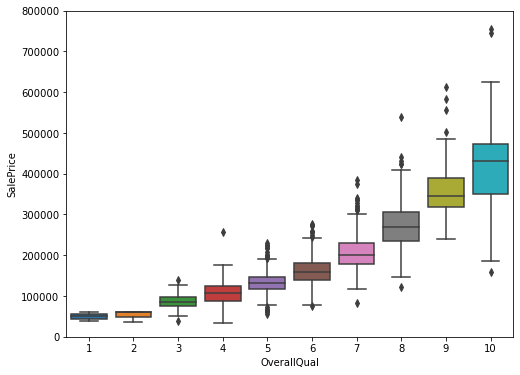

In [14]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### まとめ

説明変数として下記が使えそう．

- numerical data
  - TotalBsmtSF
- categorical data
  - YearBuilt
  - OverallQual

## 3. Keep calm and work smart

ここまで，主観的な分析を行ってきた．ここから客観的な分析を行う．

概観するため，以下を作ってみる．

- Correlation matrix (heatmap style).
- 'SalePrice' correlation matrix (zoomed heatmap style).
- Scatter plots between the most correlated variables (move like Jagger style).

### Correlation matrix

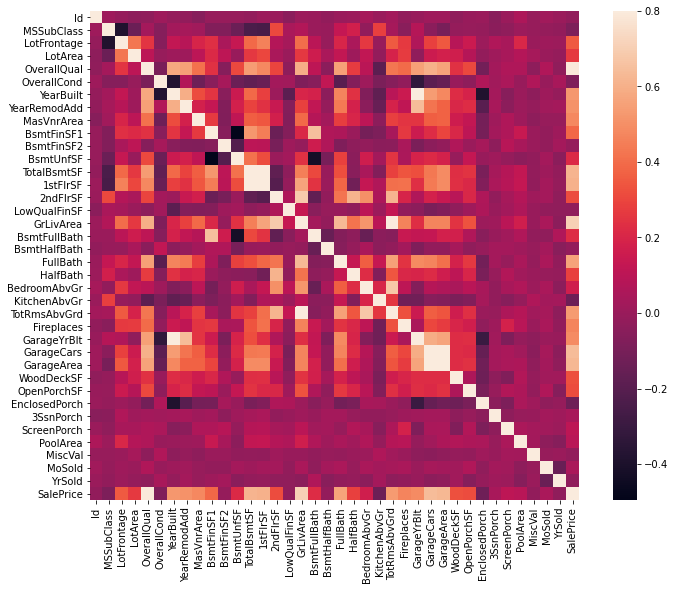

In [15]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

ヒートマップから以下のことがわかる．

変数間の相関について，以下の組の相関が高いことがわかる．

- (TotalBsmtSF, 1stFlrSF)
- (GarageYrBlt, GarageCars, GarageArea)

また，SalePrics との相関について，下記変数と相関が高いことがわかる．

- OverallQual: Rates the overall material and finish of the house
- GrLivArea: Above grade (ground) living area square feet
- TotalBsmtSF: Total square feet of basement area

上記以外に重要と思われる変数を見ていく．

### 'SalePrice' correlation matrix

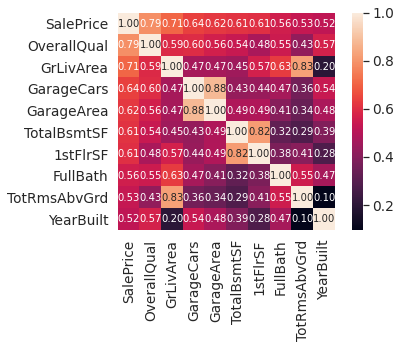

In [16]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

下記は比較的相関が強い．

- OverallQual
- GrLivArea
- GarageArea
- TotalBsmtSF

下記は本当に相関が強いのか？

- FullBath

また，下記は多少相関がある．

- YearBuilt

### Scatter plots between the most correlated variables

上記のデータ可視化から，どの変数について調べるべきか明らかになった．

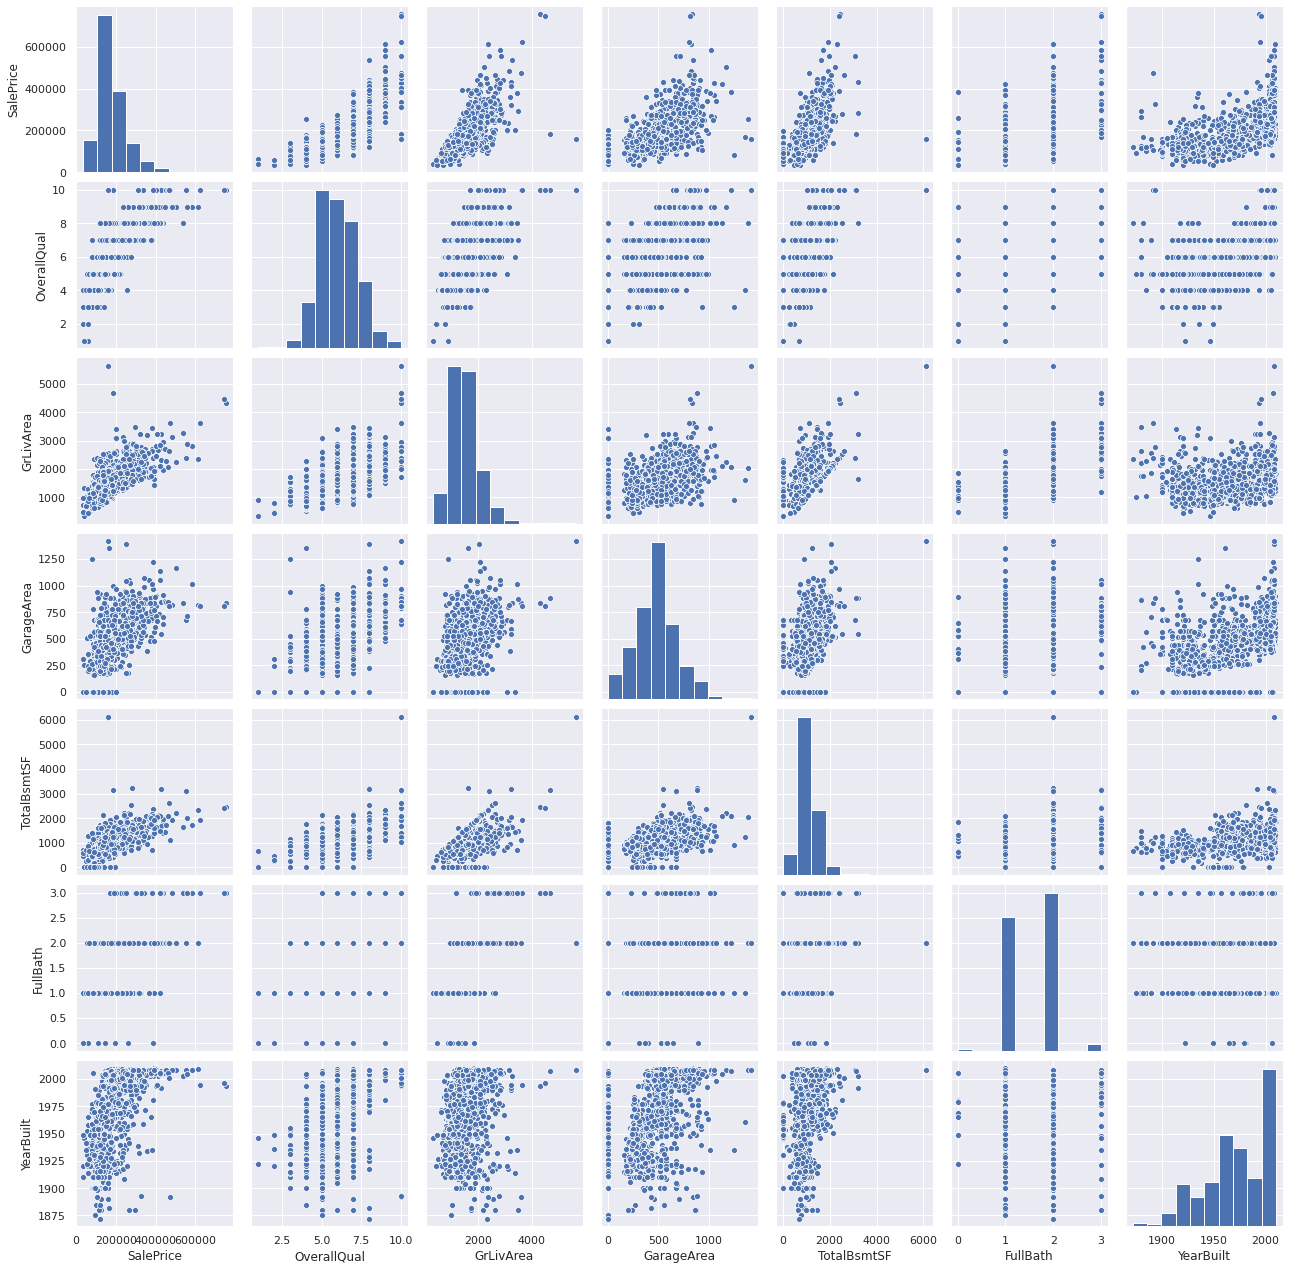

In [17]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

## 4. Missing data

欠損値について考えるとき，下記に注意することが重要である．

- どの程度あるのか
- ランダムに発生しているのか，それともパターンがあるのか

In [18]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


これら欠損値をどのように扱うべきか考える．

- 15 % 以上欠損がある場合，その特徴量は無視する
- GarageX: GarageCar があるので，無視してよい
- BsmtX: TotalBsmtSF があるので，無視してよい
- MasVnrX: 重要と判断していないので，無視してよい
- Electrical: 1 データだけなので，そのデータ(行)だけ消して，特徴量は残す

以上の内容から，下記の処理を施す．

In [19]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

### Outliar

#### 一変量解析 

ここでは，外れ値とするしきい値を定義する．
そこで，データの標準化(平均 0, 標準偏差 1 にする)を行う．

In [20]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


上記から，下記が明らかになった．

- 低い方は 0 に近い
- 高い方は 7 台がある

ただ，高い方については，この結果から外れ値と判断するのは拙速である．

#### 多変量解析

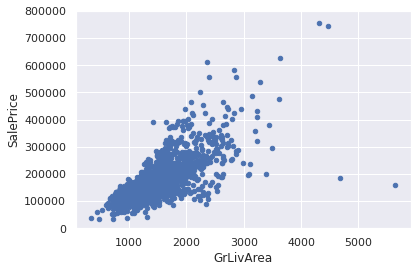

In [21]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

以下のことがわかる．

- GrLivArea の値が大きな 2 つ(4000 台後半，5000 台後半のデータ)は明らかに外れ値
- SalePrice が大きく，GrLivArea が大きな 2 つは，傾向にあっているので残す

In [22]:
df_train_order = df_train[['Id', 'GrLivArea']]
df_train_order.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,GrLivArea
1298,1299,5642
523,524,4676


In [23]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

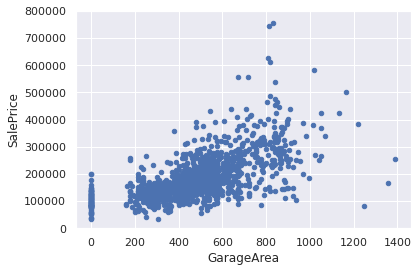

In [24]:
var = 'GarageArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

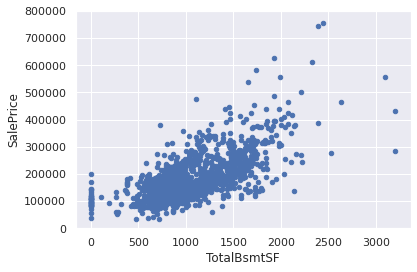

In [25]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

## 5. Getting hard core

さらに SalePrice をみていく．

[Hair et al. (2013)](https://www.amazon.com/dp/9332536503) によると，4 つの仮定を確認すべきである．

- 正規性(Normality)
- 等分散性(Homoscedasticity)
- 線形性(Linearity)
- Absence of correlated errors

#### 正規性(Normality)

いかに正規分布に近いか．
ただし 200 以上のサンプルがある場合は，大きな問題にはならない．

#### 等分散性(Homoscedasticity)

説明変数が目的変数の範囲全体で等しいレベルの分散を示すという仮定のこと．

#### 線形性(Linearity)

散布図で確認できる．
線形性がなければ，何らかのデータ変換が必要．

#### Absence of correlated errors

correlated error とは，ある変数の誤差が別の変数の誤差につながる現象のこと．
もしあることがわかった場合，それらを説明できる変数を特徴量に加える．

### Normality

- ヒストグラム(歪度，尖度)
- Normal probability plot 

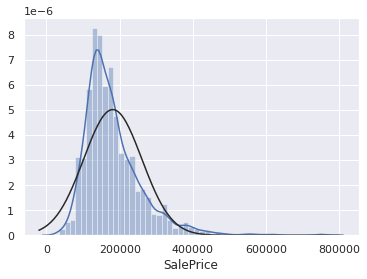

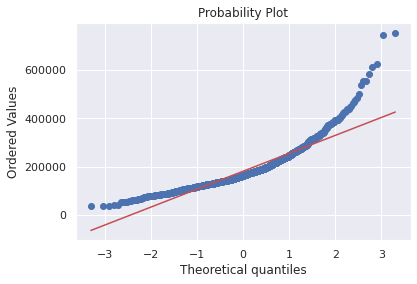

In [26]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

以下のことがわかる．

- 歪度: 正
- 尖度: 正
- Probability plot: 直線から外れている

歪度が正の場合，log 変換をするとよい．

In [27]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

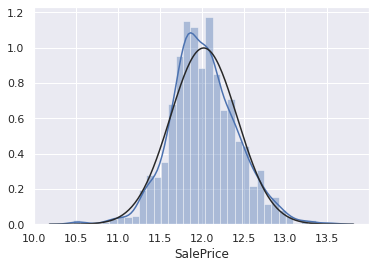

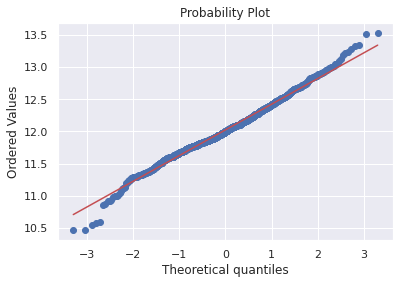

In [28]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [29]:
print('Skewness: {s:.3f}'.format(s=df_train['SalePrice'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train['SalePrice'].kurt()))

Skewness: 0.122
Kurtosis: 0.802


#### GrLivArea

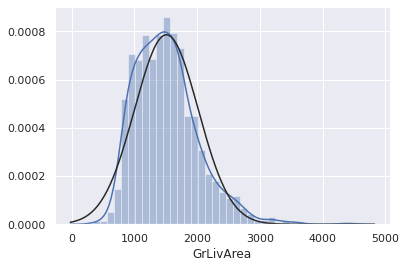

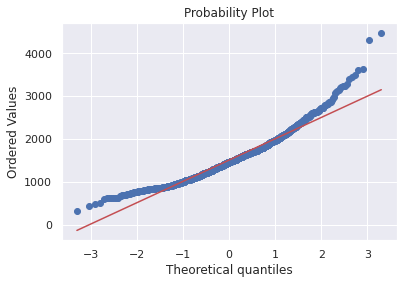

In [30]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

log 変換する．

In [31]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

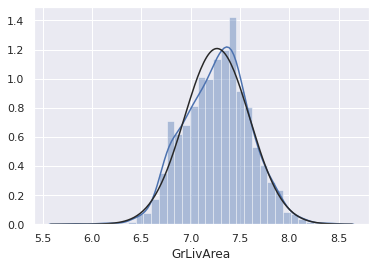

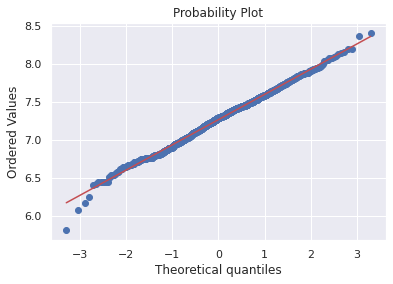

In [32]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [33]:
print('Skewness: {s:.3f}'.format(s=df_train['GrLivArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train['GrLivArea'].kurt()))

Skewness: -0.072
Kurtosis: 0.094


#### GarageArea

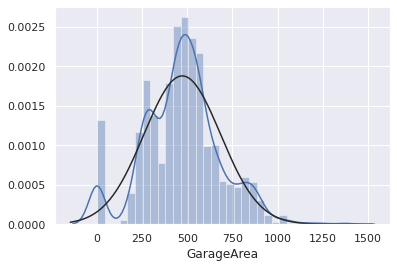

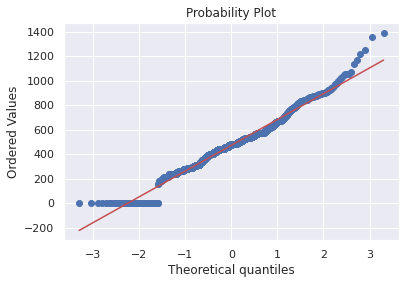

In [34]:
sns.distplot(df_train['GarageArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GarageArea'], plot=plt)

In [35]:
print('Skewness: {s:.3f}'.format(s=df_train['GarageArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train['GarageArea'].kurt()))

Skewness: 0.131
Kurtosis: 0.759


- 正の歪度
- GarageArea が 0 のデータがある(log 変換不可)
- GarageArea が 300 あたりと 500 当たりにピークがある

ここで，GarageArea が 0 か，0 でないかを示す特徴量を作る．
そうすることで，GarageArea が 0 でないものに対して，log 変換を施すことができる．

##### Box-Cox 変換

In [36]:
pt = PowerTransformer(method='box-cox')

In [37]:
df_bc = df_train.copy()

df_bc['HasGarage'] = pd.Series(len(df_bc['GarageArea']), index=df_bc.index)
df_bc['HasGarage'] = 0 
df_bc.loc[df_bc['GarageArea']>0,'HasGarage'] = 1

df_bc['HasBsmt'] = pd.Series(len(df_bc['TotalBsmtSF']), index=df_bc.index)
df_bc['HasBsmt'] = 0 
df_bc.loc[df_bc['TotalBsmtSF']>0,'HasBsmt'] = 1

df_bc.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage,HasBsmt
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2,2008,WD,Normal,12.247694,1,1
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,5,2007,WD,Normal,12.109011,1,1
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,9,2008,WD,Normal,12.317167,1,1
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,2,2006,WD,Abnorml,11.849398,1,1
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,12,2008,WD,Normal,12.429216,1,1


In [38]:
numerical_features = [
    'GrLivArea',
    'GarageArea',
    'TotalBsmtSF',
    # define following features for getting normality

]
categorical_features = [
    'OverallQual',
    'HasGarage',
    'HasBsmt',
]
features = numerical_features
features.extend(categorical_features)

target = 'SalePrice'

features_and_target = copy.deepcopy(features)
features_and_target.append(target)
df_bc = df_bc[features_and_target]
df_bc.head()

,GrLivArea,GarageArea,TotalBsmtSF,OverallQual,HasGarage,HasBsmt,SalePrice
0,7.444249,548,856,7,1,1,12.247694
1,7.140453,460,1262,6,1,1,12.109011
2,7.487734,608,920,7,1,1,12.317167
3,7.448334,642,756,7,1,1,11.849398
4,7.695303,836,1145,8,1,1,12.429216


In [39]:
df_bc = df_bc[(df_bc['GarageArea']>0) & (df_bc['TotalBsmtSF']>0)]
df_bc.head()

,GrLivArea,GarageArea,TotalBsmtSF,OverallQual,HasGarage,HasBsmt,SalePrice
0,7.444249,548,856,7,1,1,12.247694
1,7.140453,460,1262,6,1,1,12.109011
2,7.487734,608,920,7,1,1,12.317167
3,7.448334,642,756,7,1,1,11.849398
4,7.695303,836,1145,8,1,1,12.429216


In [40]:
X_and_y_for_X = df_bc.copy()

X = X_and_y_for_X \
    .drop(columns=target) \
    .drop(columns=categorical_features)
y = df_bc[target]

In [41]:
X.head()

,GrLivArea,GarageArea,TotalBsmtSF
0,7.444249,548,856
1,7.140453,460,1262
2,7.487734,608,920
3,7.448334,642,756
4,7.695303,836,1145


In [42]:
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [43]:
pt.fit_transform(X, y)

array([[ 0.49901452,  0.3791795 , -0.56124983],
       [-0.4544065 , -0.09590699,  0.55607011],
       [ 0.63576258,  0.67210265, -0.36119585],
       ...,
       [ 1.48688652, -1.56623029,  0.28452277],
       [-0.94762489, -1.675174  ,  0.09039416],
       [-0.46933572, -1.35917891,  0.54173831]])

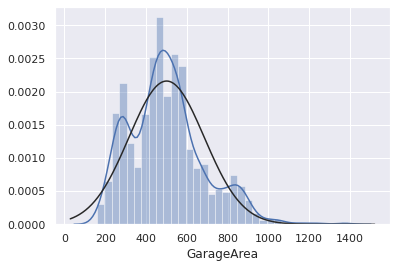

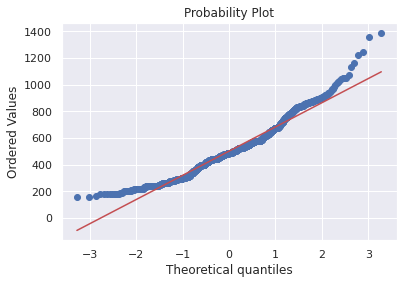

In [44]:
sns.distplot(X['GarageArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(X['GarageArea'], plot=plt)

In [45]:
print('Skewness: {s:.3f}'.format(s=X['GarageArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=X['GarageArea'].kurt()))

Skewness: 0.747
Kurtosis: 0.888


@todo: skewness が大きい

Box-Cox 変換では，全特徴量を変換するので，他の特徴量についても確認する．

- SalePrice
- GrLivArea
- TotalBsmtSF

SalePrice

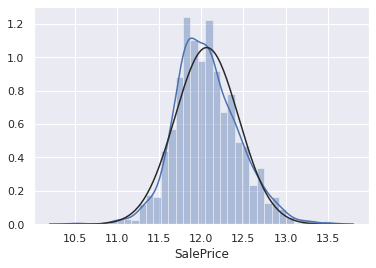

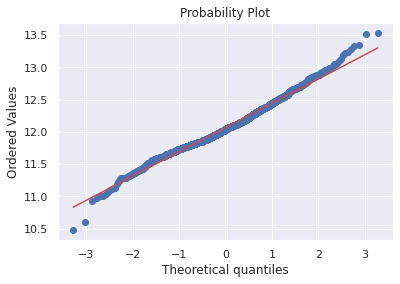

In [46]:
sns.distplot(y, fit=norm)
fig = plt.figure()
res = stats.probplot(y, plot=plt)

In [47]:
print('Skewness: {s:.3f}'.format(s=df_bc['SalePrice'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_bc['SalePrice'].kurt()))

Skewness: 0.287
Kurtosis: 0.754


GrLivArea

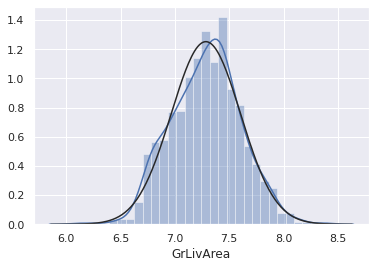

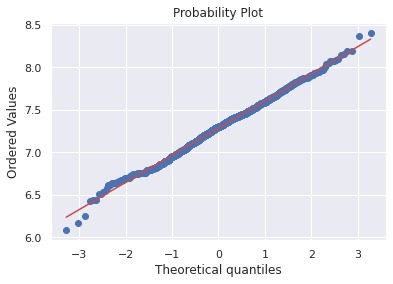

In [48]:
sns.distplot(X['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(X['GrLivArea'], plot=plt)

In [49]:
print('Skewness: {s:.3f}'.format(s=df_bc['GrLivArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_bc['GrLivArea'].kurt()))

Skewness: -0.011
Kurtosis: -0.009


TotalBsmtSF

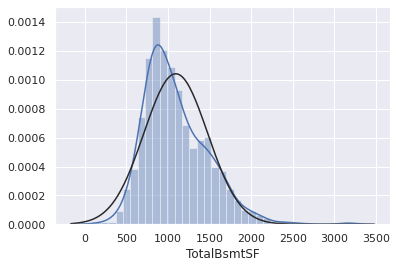

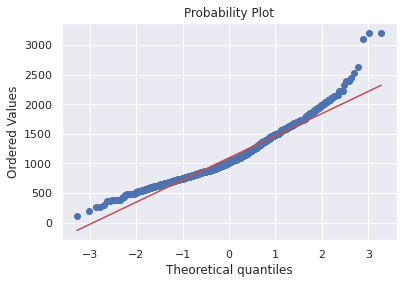

In [50]:
sns.distplot(X['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(X['TotalBsmtSF'], plot=plt)

In [51]:
print('Skewness: {s:.3f}'.format(s=df_bc['GrLivArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_bc['GrLivArea'].kurt()))

Skewness: -0.011
Kurtosis: -0.009


##### log1p() による変換

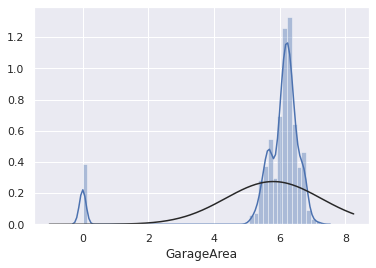

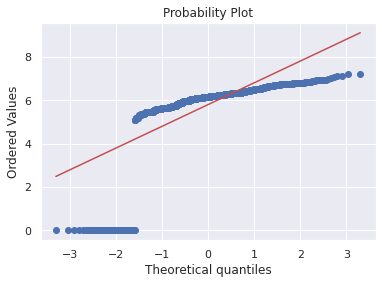

In [52]:
df_log1p = df_train.copy()

# transform
df_log1p['GarageArea'] = np.log1p(df_log1p['GarageArea'])

# visualize
sns.distplot(df_log1p['GarageArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_log1p['GarageArea'], plot=plt)

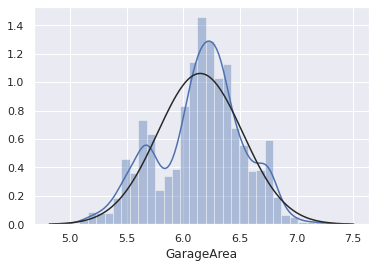

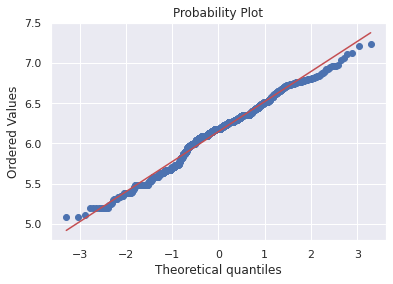

In [53]:
df_log1p = df_train.copy()
df_log1p['HasGarage'] = pd.Series(len(df_log1p['GarageArea']), index=df_log1p.index)
df_log1p['HasGarage'] = 0 
df_log1p.loc[df_log1p['GarageArea']>0,'HasGarage'] = 1

# transform
df_log1p.loc[df_log1p['HasGarage']==1,'GarageArea'] = np.log1p(df_log1p['GarageArea'])

# visualize
sns.distplot(df_log1p[df_log1p['HasGarage']==1]['GarageArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_log1p[df_log1p['HasGarage']==1]['GarageArea'], plot=plt)

In [54]:
print('Skewness: {s:.3f}'.format(s=df_log1p[df_log1p['HasGarage']==1]['GarageArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_log1p[df_log1p['HasGarage']==1]['GarageArea'].kurt()))

Skewness: -0.264
Kurtosis: -0.252


log 変換とほぼ同じ．

##### log 変換

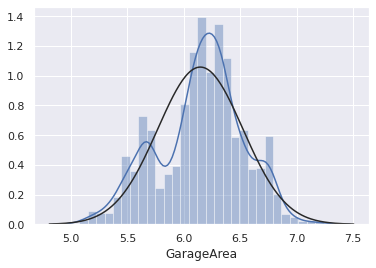

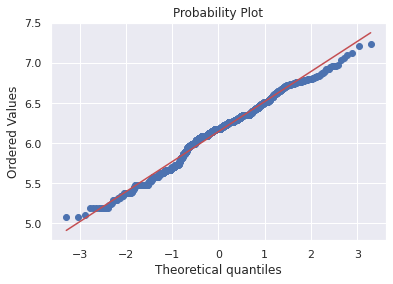

In [55]:
df_log = df_train.copy()
df_log['HasGarage'] = pd.Series(len(df_log['GarageArea']), index=df_log.index)
df_log['HasGarage'] = 0 
df_log.loc[df_log['GarageArea']>0,'HasGarage'] = 1

# transform
df_log.loc[df_log['HasGarage']==1,'GarageArea'] = np.log(df_log['GarageArea'])

# visualize
sns.distplot(df_log[df_log['HasGarage']==1]['GarageArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_log[df_log['HasGarage']==1]['GarageArea'], plot=plt)

In [56]:
print('Skewness: {s:.3f}'.format(s=df_log[df_log['HasGarage']==1]['GarageArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_log[df_log['HasGarage']==1]['GarageArea'].kurt()))

Skewness: -0.266
Kurtosis: -0.251


#### TotalBsmtSF

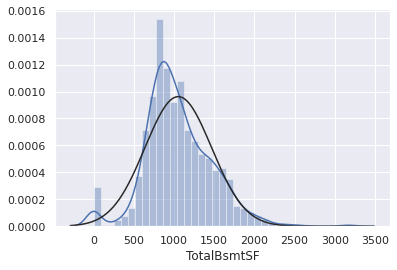

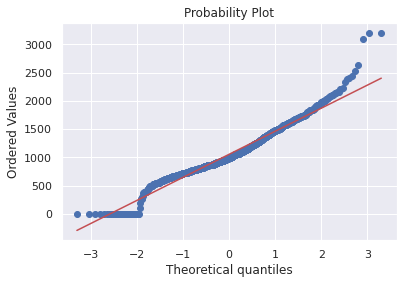

In [57]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

- 正の歪度
- TotalBsmtSF が 0 のデータがある(log 変換不可)

ここで，BsmtSF が 0 か，0 でないかを示す特徴量を作る．
そうすることで，BsmtSF が 0 でないものに対して，log 変換を施すことができる．

In [58]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [59]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

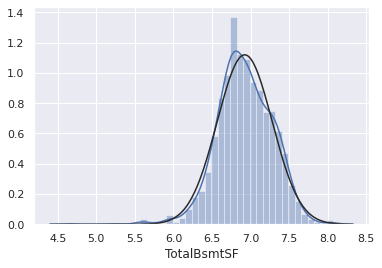

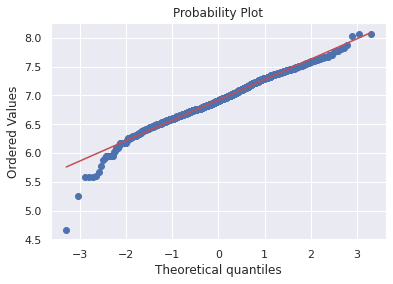

In [60]:
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [61]:
print('Skewness: {s:.3f}'.format(s=df_train[df_train['TotalBsmtSF']>0]['GarageArea'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train[df_train['TotalBsmtSF']>0]['GarageArea'].kurt()))

Skewness: 0.151
Kurtosis: 0.769


#### まとめ

| 特徴量| Skewness(log 変換) | Skewness(Box-Cox 変換) | Kurtosis(log 変換) | Kurtosis(Box-Cox 変換) |
|---:|---:|---:|---:|---:|
| SalePrice   |  0.122 |  0.287 |  0.802 |  0.754 |
| GrLivArea   | -0.072 | -0.011 |  0.094 | -0.009 |
| GarageArea  | -0.266 |  0.747 | -0.251 |  0.888 |
| TotalBsmtSF |  0.151 | -0.011 |  0.769 | -0.009 |
| Sum of abs  |  0.611 |  1.056 |  1.916 |  1.660 |

log 変換で良さそう．  
大きな差があるわけではないので，Box-Cox 変換を施した場合の予測値を使ったアンサンブルもやってみる．

### homoscedasticity

- 分散が異なる場合: 三角形になる
- 中央に集まる場合: ひし形になる

#### SalePrice and GrLivArea

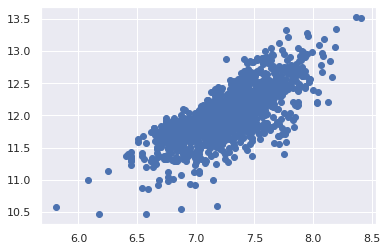

In [62]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

変換前は三角形だったが，直線に近づいた．

#### 'SalePrice' and 'GarageArea'

`np.log()` で変換したデータを見てみる．

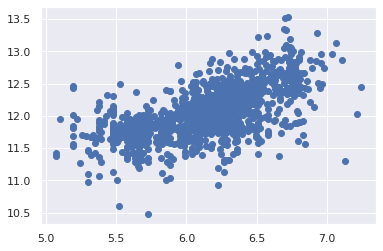

In [63]:
plt.scatter(
    df_log[
        df_log['HasGarage']==1
    ]['GarageArea'],
    df_log[
        df_log['HasGarage']==1
    ]['SalePrice']
);

#### 'SalePrice' and 'TotalBsmtSF'

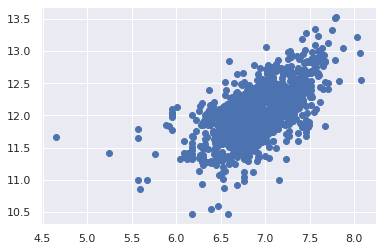

In [64]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

## 6. Conclusion

ここまで，[Hair et al. (2013)](https://www.amazon.com/dp/9332536503) で紹介されている方法を行った．
その中で，'SalePrice' 単体及び,それらと相関のある変数の分析を行った．
その後，下記を行った．

- SalePrice の分布の特徴を明らかにした
  - Skewness: 1.883
  - Kurtosis: 6.536
- 主観的に選んだ変数のうち，下記の変数に相関があることを明らかにした
  - TotalBsmtSF
  - YearBuilt
  - OverallQual
- 客観的な分析(ヒートマップ)により SalePrice と相関が高い変数は下記であることを明らかにした
  - OverallQual
  - GrLivArea
  - GarageArea
  - TotalBsmtSF
- 欠損値の処理(欠損がある特徴量を取り除く)を行った
- 外れ値の処理(下記により，外れ値を取り除く)を行った
  - 一変量解析
  - 多変量解析
- 統計的仮定の確認: 各変数について下記を確認し，変換処理，新たな特徴量の作成を行った
  - 正規性(Normality): 'HasBsmt' を作成し，log 変換を行った
  - 等分散性(Homoscedasticity)
  - 線形性(Linearity)
  - Absence of correlated errors